In [142]:
from spkit.simulate_student import SimulateStudent
import numpy as np
from spkit import bkt, pfa, tpfa
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
%load_ext autoreload

In [114]:
%autoreload 1

In [272]:
%aimport spkit.tpfa

In [273]:
%aimport spkit.pfa

In [277]:
# p(L0)
pi = [0.26, 0.74]
# p(T)
A = [[1, 0], [0.17, 0.83]]
# p(S) and p(G)
B = [[0.7, 0.3], [0.13, 0.87]]

data = []
n_questions = 10
for i in range(50):
    observations = SimulateStudent(pi, A, B).simulate(n_questions)[0]
    for question_id, outcome in enumerate(observations):
        data.append([int(not outcome), i, question_id])
q_matrix = np.array([[1,1,1]]*n_questions)
students = range(50)

In [297]:
%%time
# Instantiate model
model_bkt = bkt.BKT()
model_pfa = pfa.PFA()
model_tpfa = tpfa.TPFA()

model_bkt.fit(data, q_matrix)
model_pfa.fit(data, q_matrix)
model_tpfa.fit(data, q_matrix)

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 459 ms, sys: 4.21 ms, total: 464 ms
Wall time: 470 ms


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [315]:
def get_results(model):
    print("Results for model %s" % model)
    data_arr = np.asarray(data)
    rmse = 0
    n = 0
    score_df = []
    learning_state = {}
    outcome_all = []
    predicted_proba = []
    for student in students:
        student_idx = np.where(data_arr[:,1] == student)
        outcome = data_arr[student_idx, 0].astype('int64')
        outcome_all += outcome.tolist()[0]
        question_id = data_arr[student_idx, 2].astype('int64')
        data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
        predicted = model.predict_proba(data_student, q_matrix)
        predicted_proba += predicted[:,1].tolist()
        s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
        fpr, tpr, _ = roc_curve(model.outcomes, predicted[:,1], pos_label=1)
        auc_score = auc(fpr, tpr)
        score_df.append({"student": student,
                         "AIC": s_aic,
                         "BIC": s_bic,
                         "RMSE": s_rmse,
                         "Acc": s_acc,
                         "n questions": model.n_questions,
                         "LL": s_ll,
                         "correct_outcome": np.where(outcome == 1)[1].shape[0],
                         "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                         "AUC": auc_score})
        learning_state[student] = model.get_learning_state()
        
    return pd.DataFrame.from_dict(score_df)

def print_scores(score):
    
    # RMSE
    rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
    rmse_avg = score['RMSE'].mean()
    rmse_std = score['RMSE'].std()
    print("RMSE de treino: %.2f" % rmse_train)
    print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))
    
    # Accuracy
    acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
    acc_avg = score['Acc'].mean()
    acc_std = score['Acc'].std()
    print("Acc de treino: %.2f" % acc_train)
    print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))
    
    # AUC
    fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    auc_avg = score['AUC'].mean()
    auc_std = score['AUC'].std()
    # Sensitivity = tpr = TP/(TP+FN)
    # Specificity = 1-fpr = TN/(TN+FP)
    # Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
    J_stats = tpr - fpr
    J_opt_thresholds = thresholds[np.argmax(J_stats)]
    print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
    print("AUC de treino: %.2f" % auc_score)
    print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))
    estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
    adjusted_acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
    print("Adjusted Acc: %.2f" % adjusted_acc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [316]:
score_bkt = get_results(model_bkt)
score_pfa = get_results(model_pfa)
score_tpfa = get_results(model_tpfa)

Results for model <spkit.bkt.BKT object at 0x7fec6f916a20>
Results for model <spkit.pfa.PFA object at 0x7fec70168be0>


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/me

Results for model <spkit.tpfa.TPFA object at 0x7fec8abe6668>


/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


RMSE de treino: 0.46
RMSE médio: 0.45 +- 0.10
Acc de treino: 0.68
Acc médio: 0.68 +- 0.19
Youden's optimum threshold: 0.36
AUC de treino: 0.72
AUC médio: 0.60 +- 0.26
Adjusted Acc: 0.67


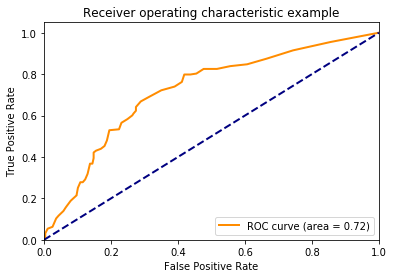

In [317]:
print_scores(score_bkt)

RMSE de treino: 0.46
RMSE médio: 0.46 +- 0.07
Acc de treino: 0.66
Acc médio: 0.66 +- 0.17
Youden's optimum threshold: 0.36
AUC de treino: 0.72
AUC médio: 0.70 +- 0.22
Adjusted Acc: 0.67


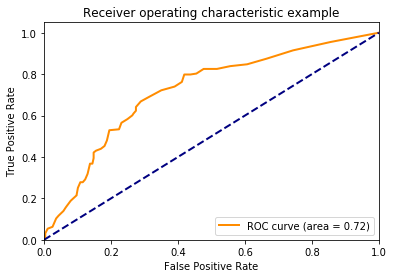

In [318]:
print_scores(score_pfa)

RMSE de treino: 0.46
RMSE médio: 0.46 +- 0.07
Acc de treino: 0.66
Acc médio: 0.66 +- 0.17
Youden's optimum threshold: 0.36
AUC de treino: 0.72
AUC médio: 0.70 +- 0.22
Adjusted Acc: 0.67


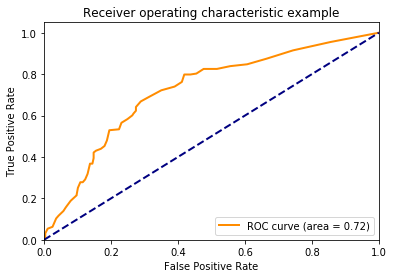

In [319]:
print_scores(score_tpfa)

In [128]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.522